In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.core.display import display, HTML
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go

%config InlineBackend.figure_format = "svg"

display(HTML("""
<style>
div.output {
    align-items: center;
}

div.output_subarea {
    overflow-x: visible;
}
</style>
"""))

In [2]:
ace_data = pd.read_pickle("../data/../data/ace_data_prepped.pkl")

# ACE Project - The Data:

The ACE dataset consists of 18 dependent features that are potentially predictive of the likelihood a child can be
treated in a community asthma clinic:
* **referral_from:** The clinical setting from which the ACE referral comes - *A&E / CCDE / ED / GP*
* **Age:** Patient age in years
* **Address:** The postcode area of the patient's address - *BD1 / BD2 etc.*
* **ethnicity:** The patients reported ethnicity (appears to be free-text i.e. not chosen from
pre-determined options)
* **gender:** Simple biological gender - *M / F*
* **referral_date:** Time of year of the referral - *spring / summer / autumn / winter*
* **referral_time:** Time of day of the referral - *morning / afternoon / evening*
* **illness_severtiy:** Reported severity of the child's illness - *mild / moderate*
* **activity_level:** Level of physical activity typical of the patient - *usual / lower*
* **gut_feeling:** Referrer's gut feeling of the child's health - *well / low concern / unwell*
* **ox_sat:** The patients blood oxygen saturation level
* **resp_rate:** The patient's respiratory rate (breaths per minute)
* **heart_rate:** The patients heart rate (beats per minute)
* **temp:** Patient body temperature (degrees C)
* **sepsis:** Any sepsis red flags - *none noted / low level*
* **safeguarding:** Are there any safeguarding concerns with the child - *Y / N*
* **drug_allergy**: Does the patient have drug allergy? *Y / N*
* **food_allergy**: Does the patient have food allergy? *Y / N*
* **other_allergy**: Does the patient have another allergy? *Y / N*

The target feature, **hospital_required** is a binary (0,1="No","Yes") indicator of weather a patient (with hindsight)
should
have been referred for hospital treatment; the data be divided up by this feature as follows:

<table style="font-size: 2em">
    <tr style="background-color:green">
        <th>Total Examples:</th>
        <td>499</td>
    </tr>
<table style="font-size: 2em">
    <tr style="background-color:orange">
        <th>Examples Requiring Hospital Treatment:</th>
        <td>82</td>
    </tr>
</table>
<table style="font-size: 2em">
    <tr style="background-color:orangered">
        <th>Proportion Requiring Hospital Treatment:</th>
        <td>16.43%</td>
    </tr>
</table>

Immediately, we can see there are going to be two major challenges:

1. **Very Few Examples / High Variance**: We don't have many examples, so variance will liekely be an issue, both in
the different
predictive features (as we'll see in greater detail below) and in the predictions
 of any models we train.
2. **Imbalanced Target / Few Positive Examples**: A small fraction of the data exhibits the charateristic we're
interested in (patients requiring hospital treatment). This will exacerbate the variance issues and make model
training more difficult. Models will have a tendency to rely on negative predictions to increase accuracy (a model
that always predicts "0" will be 83.5% accurate) and may "overfit" to the small number of positive examples.

The following is an in-depth analysis of the predictive features:

## Categorical Features

Below we break down each of the categorical features into discrete categories, and show the proportion
 of
children that require hospital treatment from each category.
As we've seen, **16.43%** of patients in the dataset required hospital treatment - <span style="color:green">Values in
green</span> signify a category with proportion lower than this mean</i> and
<span style="color:red">red values</span> higher:

In [3]:
skip_features = ["id", "hospital_reqd", "age", "heart_rate", "resp_rate",
                 "ox_sat", "temp", "ethnicity"]

cat_feature_stats = pd.DataFrame()
chi2_stats = pd.DataFrame()
for feature in ace_data.columns:

    if feature in skip_features:
        continue

    hospital_required_counts = (ace_data[[feature, "hospital_reqd"]]
                                .groupby([feature, "hospital_reqd"],
                                         as_index=False)
                                .size()
                                .pivot(index=feature,
                                       columns="hospital_reqd",
                                       values="size").fillna(0))

    chi2, p, dof, expected = chi2_contingency(hospital_required_counts.values)
    chi2_results = pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                                index=[feature])

    chi2_stats = pd.concat([chi2_stats, chi2_results])

    # skip agg feature analysis for address (too many categories)
    if feature == "address":
        continue

    feature_df = (ace_data[["hospital_reqd", feature]]
                  .groupby(feature)
                  .agg(["mean", np.std, stats.sem, "count"])).hospital_reqd

    idx_tuples = [(feature_df.index.name, cat)
                  for cat in feature_df.index.categories]

    new_idx = pd.MultiIndex.from_tuples(idx_tuples, names=["feature", "values"])

    feature_df.set_index(new_idx, inplace=True)
    cat_feature_stats = pd.concat([cat_feature_stats, feature_df])

cat_feature_stats = cat_feature_stats.rename(columns={
    "mean": "Mean",
    "std": "Standard Dev",
    "sem": "Standard Error",
    "count": "Count"
})


rnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=rnorm, cmap=red_cmap)

gnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
green_cmap = sns.color_palette("Greens", as_cmap=True)
green_m = cm.ScalarMappable(norm=gnorm, cmap=green_cmap)

def highlight_low_high(df):
    if df["Mean"] < ace_data.hospital_reqd.mean():
        mean_diff = ace_data.hospital_reqd.mean() - df["Mean"] + 0.02
        mean_diff = min(mean_diff, 0.12)
        rgba_value = tuple(np.array(green_m.to_rgba(mean_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * 4
    else:
        mean_diff = df["Mean"] - ace_data.hospital_reqd.mean()
        mean_diff = min(mean_diff, 0.12)
        rgba_value = tuple(np.array(red_m.to_rgba(mean_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * 4

cat_feature_stats.iloc[:30,:].style.apply(highlight_low_high,
                              axis=1)

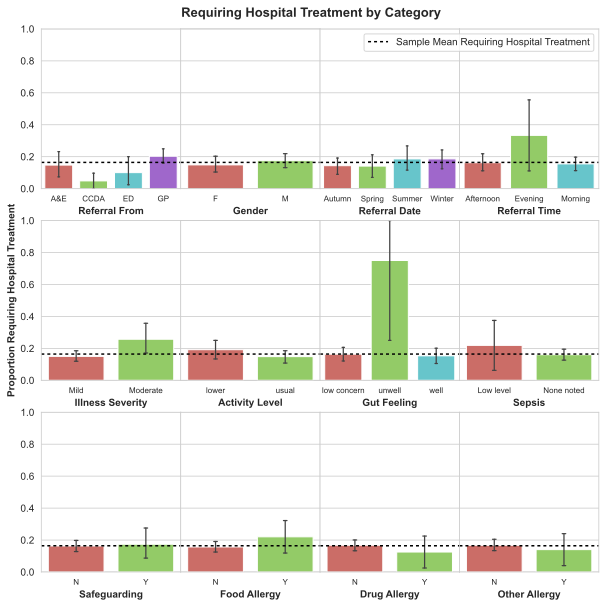

In [4]:
bar_plot_features = ['referral_from', 'gender', 'referral_date', 'referral_time',
                     'illness_severity', 'activity_level', 'gut_feeling',
                     'sepsis', 'safeguarding', 'food_allergy', 'drug_allergy',
                     'other_allergy']

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(10,10))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by Category",
             y=0.91,
             size=13,
             weight="bold")

for n, feature in enumerate(bar_plot_features):
    row, col = int(np.floor(n/4)), n%4
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.05,
                     ax=axs[row, col],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    line = ax.axhline(ace_data.hospital_reqd.mean(),
                      color="black",
                      linewidth=1.5,
                      dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label, fontweight="bold")
    ax.tick_params(axis='x', which='major', labelsize=8)
    if row == 1:
        ax.set_ylabel("Proportion Requiring Hospital Treatment", fontweight="bold")
    else:
        ax.set_ylabel("")

    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")
    if col == 3 and row == 0:
        mean_line = mpl.lines.Line2D([], [],
                                     color='black',
                                     label='Sample Mean Requiring Hospital Treatment',
                                     dashes=(2,2),
                                     linewidth=1.5)
        ax.legend(handles=[mean_line],
                  fontsize=10)

Address Feature (too many categories to be included with other grouped analysis above):

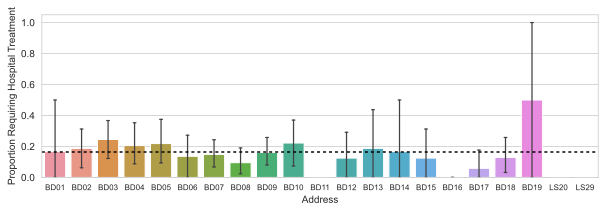

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,3))
fig = sns.barplot(data=ace_data,
                  x="address",
                  y="hospital_reqd",
                  errwidth=1.25,
                  capsize=.1)
fig.set_xlabel("Address")
fig.set_ylabel("Proportion Requiring Hospital Treatment")
fig.tick_params(axis='x', which='major', labelsize=8)
line = fig.axhline(ace_data.hospital_reqd.mean(),
                  color="black",
                  linewidth=1.5,
                  dashes=(2,2))

We can clearly see the variance issues referenced above. The mean "hospital_required" figure for each
category show a high variance / standard deviation and the errors for each
category
overlap significantly with
one
another (and the sample mean). This is also reflected in a simple chi<sup>2</sup> test:

### Pearson's Chi<sup>2</sup> Significance figures

<span style="color: green">Figures in green</span> have a p value < 0.05, <span style="color: red">those in
red</span> have a p value greater than 0.05, the shade of red signifying the degree of the difference:

In [6]:
pnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.5)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=pnorm, cmap=red_cmap)

def highlight_significant(df, ncol):
    if df.p < 0.05:
        return ["background-color: #248c46"] * ncol
    else:
        p_diff = df.p - .05
        p_diff = min(p_diff, 0.4)
        rgba_value = tuple(np.array(red_m.to_rgba(p_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * ncol

(chi2_stats.iloc[:13,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
gut_feeling,10.201133,0.006093,2
referral_from,10.675960,0.013614,3
illness_severity,4.273838,0.038703,1
referral_time,3.931710,0.140036,2
activity_level,1.267564,0.260224,1
food_allergy,1.101011,0.294044,1
gender,0.439708,0.507263,1
sepsis,0.374771,0.540415,1
drug_allergy,0.227928,0.633065,1
referral_date,1.711824,0.634308,3


Overall it is clear that there isn't a statistically significant correlation between many of the individual features and
 the target / independent variable. The data suggest a strong possibility the observed differences
 between categories occur by chance. That's not to say there aren't differences, just that these can't be clearly
 determined from the data.

Also some notes on the significant features:

**gut_feeling** / **illness_severity** - It's certainly reassuring that the opinion of medical professionals is
significant! That said, very few patients are assigned to the most predictive categories i.e. a patient being deemed
"unwell" is a very strong predictor, but only a minute fraction of the examples are assigned this category. As such,
these features can't be used to divide the vast majority of the data.

**referral_from** - I'm there may be a "confounding element" to this feature i.e. there is some out-of-sample selection
happening that means a greater proportion of patients seen at the GP (an the opposite for the other categories) are
expected to require hospital
treatment.
As a
 hypothetical example, the most ill patients treated at A&E may be admitted to hospital without referral to ACE (and
 so aren't featured in the data), so only the milder cases are referred from A&E to ACE. *Maybe Mat can shed some more
  light on this?*

## Numerical Features

The story is similar with the numeric features:

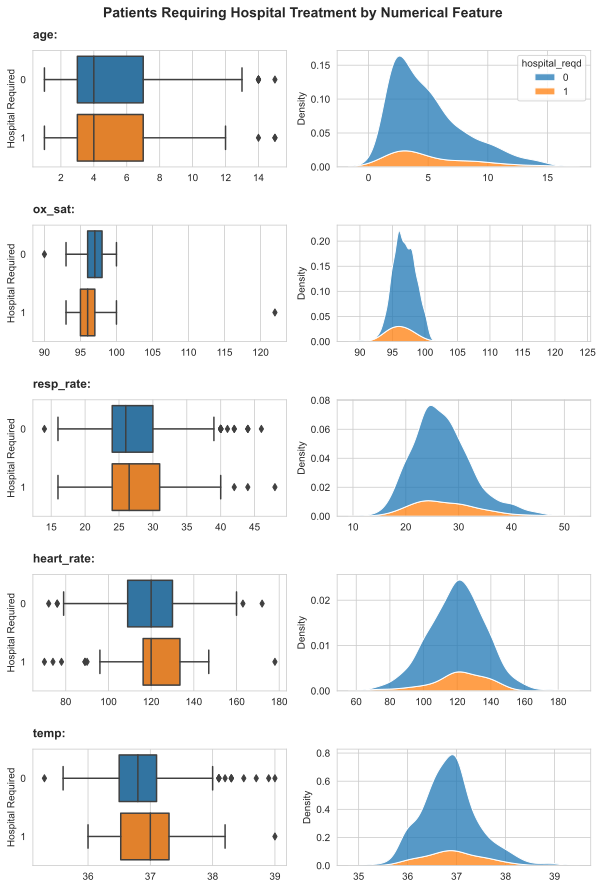

In [7]:
num_features = ['age', 'ox_sat', 'resp_rate', 'heart_rate', 'temp']

fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10,15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Patients Requiring Hospital Treatment by Numerical Feature",
             y=0.92,
             size=14,
             weight="bold")
for n, feature in enumerate(num_features):
    ax1 = sns.boxplot(data=ace_data,
                      y="hospital_reqd",
                      x=feature,
                      orient="h",
                      ax=axs[n, 0])
    ax1.set_xlabel("")
    ax1.set_ylabel("Hospital Required")
    ax1.set_title(f"{feature}:", loc="left", pad=12, fontsize=12, fontweight="bold")
    ax2 = sns.kdeplot(data=ace_data,
                      x=feature,
                      hue="hospital_reqd",
                      multiple="stack",
                      ax=axs[n,1])
    ax2.set_xlabel("")
    ax2.set_ylabel("Density")
    if n > 0:
        ax2.legend(handles=[]).remove()



It seems there are some differences between the distributions of the numeric features for patients requiring /
 not requiring hospital treatment and the differences seem to follow intuition (i.e. patients requiring a hospital
 stay typically exhibit higher heart / respiratory rates).
 However, again there is a very high level of variance and, as shown by the Pearson's R figures below, weak / no
 evidence of a
 statistically
 significant
 correlation between these features and requiring hospital treatment:

 ### Pearsons-r Significance Figures:

In [8]:
pearsons_r_stats = {
    "r": [],
    "p": []
}

for feature in num_features:
    feature_data = ace_data[[feature, "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(feature_data[feature],
                          feature_data.hospital_reqd)
    pearsons_r_stats["r"].append(r)
    pearsons_r_stats["p"].append(p)

pearsons_r_stats = (pd.DataFrame(pearsons_r_stats, index=num_features)
                  .sort_values("p"))
pearsons_r_stats.style.apply(highlight_significant, ncol=2, axis=1)


,r,p
ox_sat,-0.079778,0.077991
temp,0.064907,0.175115
resp_rate,0.056062,0.216371
heart_rate,0.045200,0.318036
age,0.032073,0.474706


## Engineered features / Interaction Effects

### Ethnicity

The ethnicity feature is not included in the above analysis, as an impractical number of differing ethnicities are
reported,
 resulting in a majority of sparse ethnic categories:

* the largest ethnic categories are "Pakistani" - 239 examples - and "British" - 166 examples
* there are 31 other categores, each of which represents 12 or fewer patients
* 28 of these categores represnt 4 or fewer patients

Left in its "raw" state, the ethnicity category would not be of much use, given this sparsity. However, the feature may well contain useful information. It remains to "engineer" / "clean" these ethnic categories into a more manageable grouping. Ruaridh and I took different approaches to this:

* Ruaridh simply categorised the reported ethnicities other than "Pakistani" / "British" as "Other" - I have named
this feature "simple_ethnicity"
* I grouped the ethnicities into "European", "Asian" and "Other", using the "Other" category for any ethnicities that
 did not obviously fit with the first two - I have named this feature
"group_ethnicity"

The resulting categories divide the data as follows:

In [9]:
cat_feature_stats.iloc[30:36,:].style.apply(highlight_low_high,
                              axis=1)

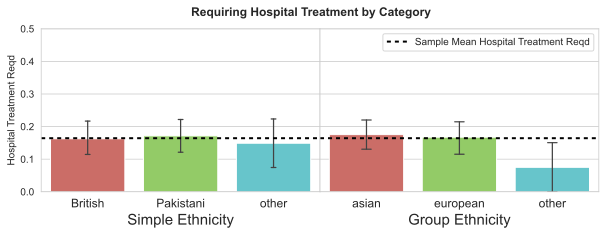

In [10]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by Category",
             size=12,
             weight="bold")

ax1 = sns.barplot(data=ace_data,
                  x="simple_ethnicity",
                  y="hospital_reqd",
                  errwidth=1.25, capsize=.05,
                  ax=axs[0],
                  palette=sns.color_palette("hls", 4))
# draw line of overall mean hospital admissions
ax1.axhline(ace_data.hospital_reqd.mean(),
            color="black",
            linewidth=2,
            dashes=(2,2))
ax1.set_xlabel("Simple Ethnicity", size=15)
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.set_ylabel("Hospital Treatment Reqd")

ax1.set(ylim=(0,.5))

ax2 = sns.barplot(data=ace_data,
                  x="group_ethnicity",
                  y="hospital_reqd",
                  errwidth=1.25,
                  capsize=.1,
                  ax=axs[1],
                  palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
ax2.axhline(ace_data.hospital_reqd.mean(),
            color="black",
            linewidth=2,
            dashes=(2,2))
ax2.set_xlabel("Group Ethnicity", size=15)
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.set(yticklabels=[], ylabel="")
ax2.set(ylim=(0,.5))
mean_line = mpl.lines.Line2D([], [],
                             color='black',
                             label='Sample Mean Hospital Treatment Reqd',
                             dashes=(2,2), linewidth=2)
ax2 = ax2.legend(handles=[mean_line])

It appears that grouping other asian / european ethnicities together results in a more significant correlation with
hospital treatment - this is reflected in the chi<sup>2</sup> figures

In [11]:
(chi2_stats.iloc[13:15,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
group_ethnicity,2.576695,0.275726,2
simple_ethnicity,0.256294,0.879724,2


### ACE referral criteria

ACE has its own set of referral criteria. These may be particularly useful as they highlight interactions between
several of the dataset features:

* Oxygen Saturation: anything above 94% is considered acceptable for community treatment
* Heart / Respiratory Rate: The criteria stipulate high / low values for patients in three different age groups (0-5,
 6-11, 12+)
* Qualitative criteria: The guidelines also include a number of qualitative measures, such as "able to complete
sentences" and "Good air entry with some wheeze"

I used these guidelines to create the following features:
* **"ox_sat_low"**: < 94% = "Y", otherwise "N"
* **"age_range"**: The three age groupings from the heart/respiratory rate rules are used as their own feature:
"pre_school" = 0-5, "primary" = 6-11, "secondary" = 12 +
* **"ace_heart_rate_cat"/"ace_resp_rate_cat"**: Using the high/low figures from the guidelines within each age group,
examples are assigned one of "high"/"low"/"normal" - see crib sheets for  further info
* **meets_ace_criteria**: examples require "ox_sat_low" = "N" and "ace_heart_rate_cat"/"ace_resp_rate_cat" = "normal"
 to meet the criteria. The "illness_severity" and "gut_feeling" features as proxies for the
 qualitative guidelines that don't feature in the dataset - so examples require  "gut_feeling" =
 "well"/"low_concern" and "illness_severity" = "low" to meet the criteria.

These features divide into the following distributions:

In [12]:
cat_feature_stats.iloc[36:49,:].style.apply(highlight_low_high,
                              axis=1)

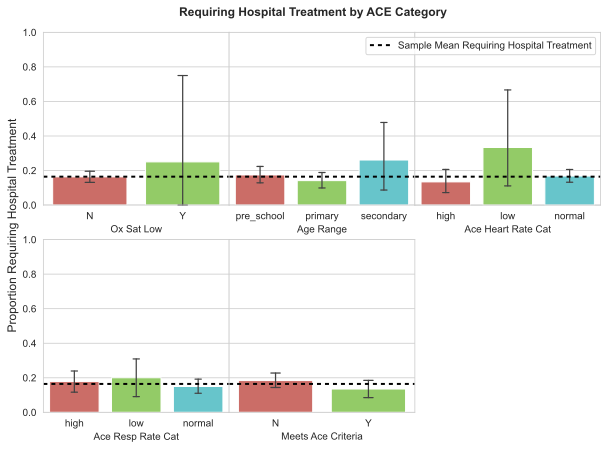

In [13]:
ace_features = ["ox_sat_low", "age_range", "ace_heart_rate_cat", "ace_resp_rate_cat",
                "meets_ace_criteria"]

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10,7))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by ACE Category",
             y=0.93,
             size=12,
             weight="bold")

for n, feature in enumerate(ace_features):
    row, col = int(np.floor(n/3)), n%3
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[row, col],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    line = ax.axhline(ace_data.hospital_reqd.mean(),
                      color="black",
                      linewidth=2,
                      dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label)
    ax.tick_params(axis='x', which='major')
    if row == 0:
        ax.set_ylabel("Proportion Requiring Hospital Treatment",
                      horizontalalignment="right",
                      size=12)
    else:
        ax.set_ylabel("")

    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")
    if col == 2 and row == 0:
        mean_line = mpl.lines.Line2D([], [],
                                     color='black',
                                     label='Sample Mean Requiring Hospital Treatment',
                                     dashes=(2,2),
                                     linewidth=2)
        ax.legend(handles=[mean_line],
                  fontsize=10)

axs = axs[1,2].axis("off")

As with the other features, the correlation between the above categories and the target are mostly as expected (e.g. a
lower
proportion of Patients meeting the ACE criteria require hospital treatment) - the exception being lower number of
patients with a
"high" heart rate requiring hospital treatment. The variance shown is again very high and so its difficult to be
confident in the reliability of any of these differences -
 again this is reflected in the chi<sup>2</sup> figures:

In [14]:
(chi2_stats.iloc[15:20,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
meets_ace_criteria,1.749478,0.185942,1
ace_heart_rate_cat,2.558079,0.278304,2
age_range,2.553815,0.278898,2
ace_resp_rate_cat,1.180700,0.554133,2
ox_sat_low,0.045418,0.831238,1


### Advanced Paediatric Life Support (APLS) normal values

Mat has also provided figures from the APLS which use a greater number of age groupings to determine low/normal/high
ranges of heart and respiratory rate. The rules themselves are more verbose than is worth detailing here. Simply note
 the APLS criteria use a more granular age groupings than the ACE criteria to describe a low/normal/high heart rate:

In [15]:
cat_feature_stats.iloc[49:,:].style.apply(highlight_low_high,
                              axis=1)

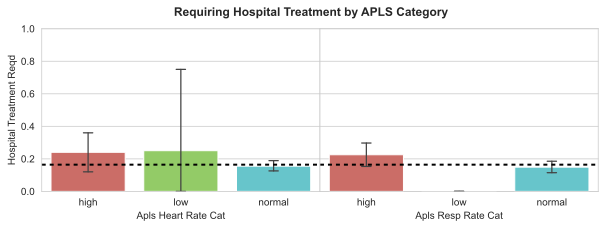

In [16]:

ace_features = ["apls_heart_rate_cat", "apls_resp_rate_cat"]

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by APLS Category",
             size=12,
             weight="bold")

for n, feature in enumerate(ace_features):
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[n],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    line = ax.axhline(ace_data.hospital_reqd.mean(),
                      color="black",
                      linewidth=2,
                      dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label)
    if n == 0:
        ax.set_ylabel("Hospital Treatment Reqd")
    else:
        ax.set_ylabel("")

    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if  n != 0:
        ax.set(yticklabels=[],
               ylabel="")
    if n == 2:
        mean_line = mpl.lines.Line2D([], [],
                                     color='black',
                                     label='Sample Mean Requiring Hospital Treatment',
                                     dashes=(2,2),
                                     linewidth=2)
        ax.legend(handles=[mean_line],
                  fontsize=15)

The "apls_heart_rate_cat" has much the same story as the other features - the proportions are as we may expect (higher rates of hospitalisation for high / low) but the variance is so high its difficult to rely on these figures. 

The "apls_resp_rate_cat" is a little more interesting, given the perfect agreement of zero hospitalisations for patients with a "low" respiratory rate, of which there are only 5. This is reflected in the chi<sup>2</sup> statistics which show a relatively low p-value for this feature. 

In [17]:
(chi2_stats.iloc[20:,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
apls_resp_rate_cat,4.651088,0.097730,2
apls_heart_rate_cat,2.577296,0.275643,2


This should be "taken with a pinch of salt" given the low number of patients, as it's likely this perfect separation would not continue with more data - which would then result in a marked jump in standard deviation / variance, and a respective drop in significance.

## Closing Comments:

I have attempted to identify useful interaction effects between two or more variables. For example, "age" broken down
 by "referral_from" might highlight that a much higher proportion of  younger patients referred from the GP require
 hospital treatment. This hasn't unearthed any significant relationships thus far - simply more sparse groupings and
 erratic results with very high variance - so I've chosen to exclude this for brevity's sake. It's possible I'll
 identify such relationships later, particularly if a trained model identifies a useful group of features that can
 be interpreted locally (example by example) or globally (the overall rules the model applies). Put simply, this
 is by no means a comprehensive analysis and there will
 likely be more interesting / useful insights that come later.

Also, despite the high variance across the dataset and the struggle to find significant features, that isn't to say
we train a reasonably accurate model as things stand. It should be stressed however, that we aren't likely to see an
amazing level of accuracy using the current dataset, and that any results may not generalise well to new data. This has
been the case so far with Ruaridh's
comprehensive preliminary work, and with the short time I've been experimenting. It's likely the data will need to be
 augmented with additional information (i.e. primary care data / additional patient treatment info) to reach a useful
  level of accuracy. I'll have an intial analysis of the modelling side of things ready soon.

  Let me know if you have any questions/feedback!
